# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

In [69]:
# Подключение Google Drive
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ROOT = Path('/content/drive/MyDrive')

# Настройка структуры папок проекта
PROJECT_DIR = ROOT / 'price_forecasting'
DATA = PROJECT_DIR / 'data'
RAW = DATA / 'raw'
PROCESSED = DATA / 'processed'
MODELS = PROJECT_DIR / 'models'
MODELS.mkdir(exist_ok=True)

print('Проектная папка подключена:', PROJECT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Проектная папка подключена: /content/drive/MyDrive/price_forecasting


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted', rc={'figure.figsize':(12,6)})

In [71]:
train_df = pd.read_parquet(PROCESSED / 'train_features_final.parquet')
val_df = pd.read_parquet(PROCESSED / 'val_features_final.parquet')
test_df = pd.read_parquet(PROCESSED / 'test_features_final.parquet')

# Проверка загрузки
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (35743638, 22)
Validation shape: (5986318, 22)
Test shape: (6005441, 22)


,store_id,item_id,wm_yr_wk,sell_price,date,month,year,event_name_1,event_type_1,event_name_2,...,snap_TX,snap_WI,day_of_week,is_weekend,log_sell_price,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting
0,CA_1,FOODS_1_001,11101,2.0,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,5,1,1.098612,0,0,0,0,0
1,CA_1,FOODS_1_001,11101,2.0,2011-01-30,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,6,1,1.098612,0,0,0,0,0
2,CA_1,FOODS_1_001,11101,2.0,2011-01-31,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,0,0,1.098612,0,0,0,0,0
3,CA_1,FOODS_1_001,11101,2.0,2011-02-01,2,2011,NoEvent,NoEvent,NoEvent,...,1,0,1,0,1.098612,0,0,0,0,0
4,CA_1,FOODS_1_001,11101,2.0,2011-02-02,2,2011,NoEvent,NoEvent,NoEvent,...,0,1,2,0,1.098612,0,0,0,0,0


            log_sell_price
date                      
2011-01-29        1.473295
2011-01-30        1.473295
2011-01-31        1.473295
2011-02-01        1.473295
2011-02-02        1.473295
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1772 entries, 2011-01-29 to 2015-12-05
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   log_sell_price  1772 non-null   float64
dtypes: float64(1)
memory usage: 27.7 KB
None


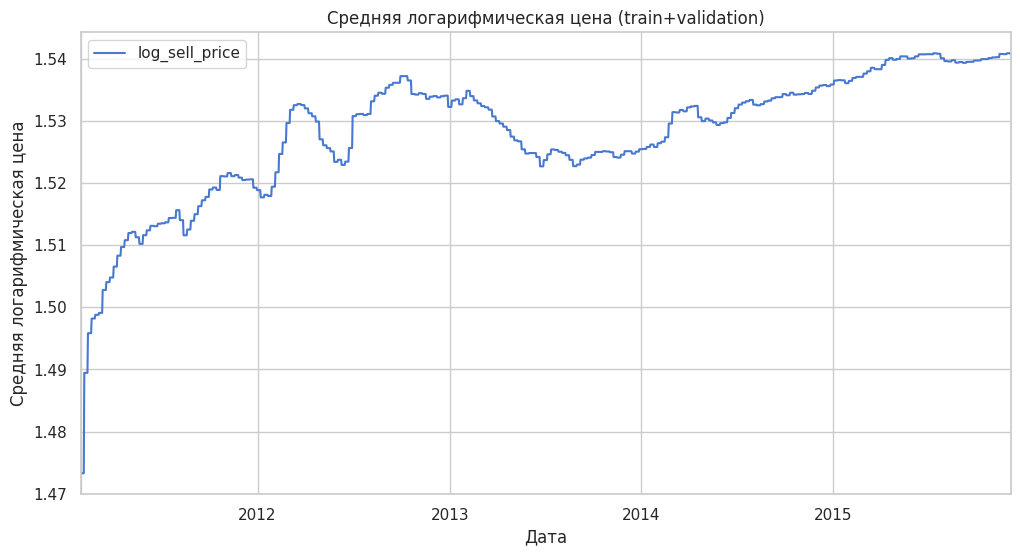

In [72]:
# Подготовка временного ряда только на основе train и validation данных
train_val_df = pd.concat([train_df, val_df])[['date', 'log_sell_price']]

# Установка datetime индекса и сортировка
train_val_df['date'] = pd.to_datetime(train_val_df['date'])
train_val_df.sort_values('date', inplace=True)
train_val_df.set_index('date', inplace=True)

# Средняя логарифмическая цена по дням
train_ts_df = train_val_df.resample('D').mean().fillna(method='ffill')

# Проверка полученного ряда
print(train_ts_df.head())
print(train_ts_df.info())

# Визуализация ряда
train_ts_df.plot(title='Средняя логарифмическая цена (train+validation)')
plt.xlabel('Дата')
plt.ylabel('Средняя логарифмическая цена')
plt.show()

In [73]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_ts_df['log_sell_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    print("Ряд НЕ стационарный -> требуется дифференцирование.")
else:
    print("Ряд стационарный -> дифференцирование не требуется.")

ADF Statistic: -2.8102952156724896
p-value: 0.05681815176444465
Ряд НЕ стационарный -> требуется дифференцирование.


### Вывод по проверке стационарности:

- Значение ADF статистики: **-2.8103**
- p-value: **0.0568**

Так как p-value > 0.05, временной ряд является **нестационарным** и требует дифференцирования (d=1).


            log_sell_price
date                      
2011-01-30             0.0
2011-01-31             0.0
2011-02-01             0.0
2011-02-02             0.0
2011-02-03             0.0


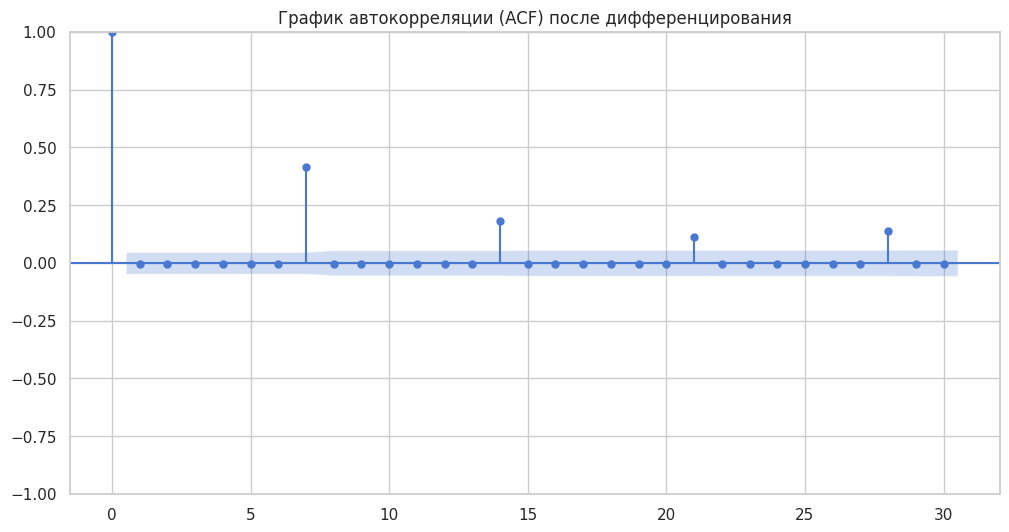

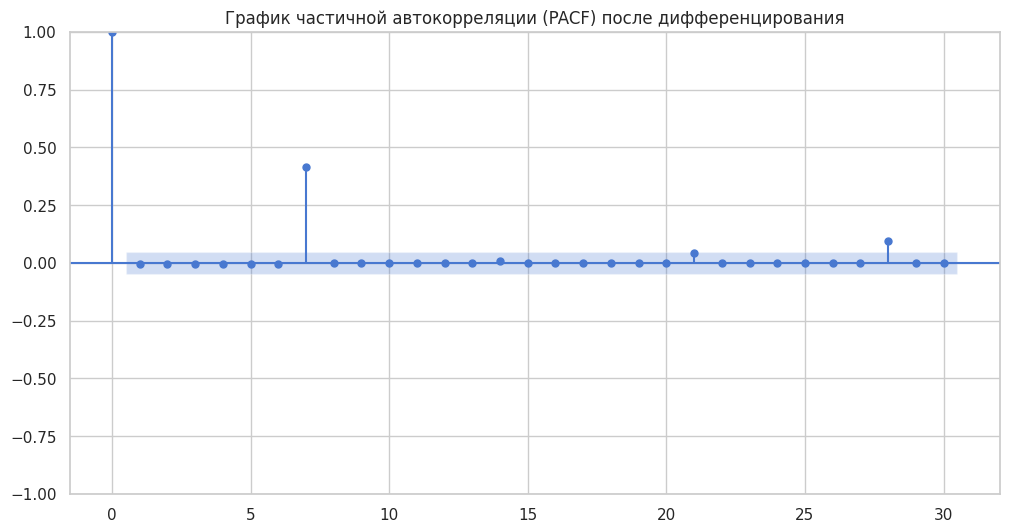

In [74]:
# Дифференцирование ряда
diff_train_ts_df = train_ts_df.diff().dropna()

# Проверка ряда
print(diff_train_ts_df.head())

# Графики автокорреляции и частичной автокорреляции после дифференцирования
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_train_ts_df, lags=30)
plt.title('График автокорреляции (ACF) после дифференцирования')
plt.show()

plot_pacf(diff_train_ts_df, lags=30)
plt.title('График частичной автокорреляции (PACF) после дифференцирования')
plt.show()

### Вывод по анализу автокорреляций после дифференцирования:

После первого порядка дифференцирования временной ряд стал стационарным, что подтверждают графики автокорреляции:

- **ACF** демонстрирует резкое затухание после первого лага, что предполагает выбор параметра скользящего среднего (q) примерно равным **1**.
- **PACF** также показывает резкое затухание после первого лага, что говорит о возможном выборе параметра авторегрессии (p) равным **1**.

Таким образом, предварительные параметры модели ARIMA можно определить как:

- p = 1
- d = 1
- q = 1

In [75]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

p, d = 1, 1
q_values = [1, 2]

def safe_mape(y_true, y_pred, epsilon=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

for q in q_values:
    mape_scores = []
    print(f"Оценка модели ARIMA({p},{d},{q}):")
    for train_index, test_index in tscv.split(train_ts_df):
        train, test = train_ts_df.iloc[train_index], train_ts_df.iloc[test_index]

        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()

        predictions = model_fit.forecast(steps=len(test))

        mape = safe_mape(test.values, predictions.values)
        mape_scores.append(mape)

    print(f"Средний безопасный MAPE для q={q}: {np.mean(mape_scores):.4f}%")

Оценка модели ARIMA(1,1,1):
Средний безопасный MAPE для q=1: 0.2561%
Оценка модели ARIMA(1,1,2):
Средний безопасный MAPE для q=2: 0.2561%


### Вывод по кросс-валидации модели ARIMA:

Обе протестированные модели показали одинаковые результаты по средней метрике MAPE:

- ARIMA(1,1,1): **0.2561%**
- ARIMA(1,1,2): **0.2561%**

Поскольку результаты практически идентичны, предпочтительнее выбрать менее сложную модель (с меньшим числом параметров), то есть **ARIMA(1,1,1)**.

Финальный безопасный MAPE на тестовом наборе: 0.0124%


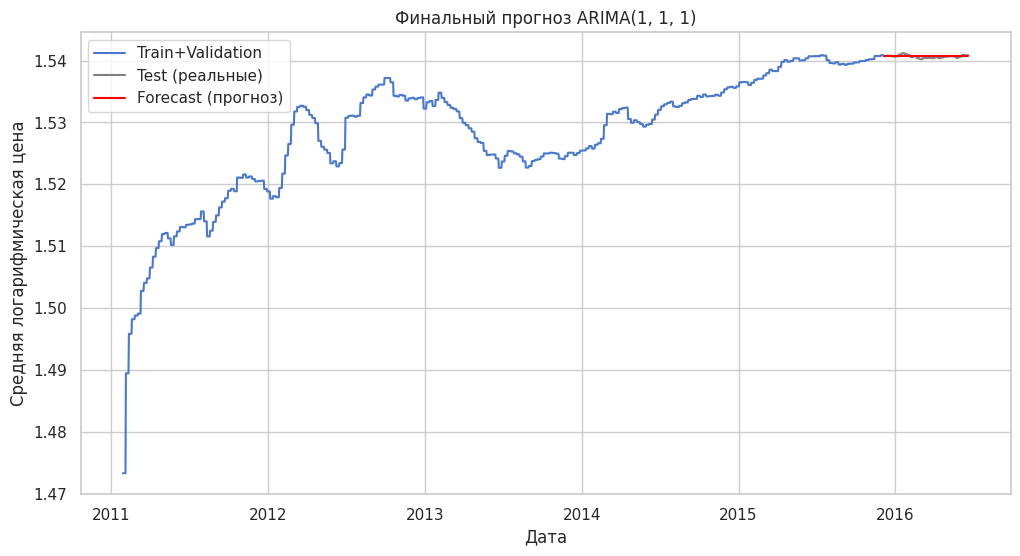

In [76]:
# Финальная модель ARIMA(1,1,1)
final_order = (1, 1, 1)

# Обучение на полном наборе train+validation
model_final = ARIMA(train_ts_df, order=final_order)
model_final_fit = model_final.fit()

# Подготовка тестовых данных
test_df_arima = test_df[['date', 'log_sell_price']].copy()
test_df_arima['date'] = pd.to_datetime(test_df_arima['date'])
test_df_arima.set_index('date', inplace=True)
test_ts_df = test_df_arima.resample('D').mean().fillna(method='ffill')

# Прогнозирование на тестовом наборе
forecast_steps = len(test_ts_df)
forecast_final = model_final_fit.forecast(steps=forecast_steps)

# Безопасный MAPE для финального прогноза
final_mape = safe_mape(test_ts_df.values, forecast_final.values)
print(f'Финальный безопасный MAPE на тестовом наборе: {final_mape:.4f}%')

# Визуализация прогноза
plt.figure(figsize=(12,6))
plt.plot(train_ts_df.index, train_ts_df, label='Train+Validation')
plt.plot(test_ts_df.index, test_ts_df, label='Test (реальные)', color='gray')
plt.plot(test_ts_df.index, forecast_final, label='Forecast (прогноз)', color='red')
plt.xlabel('Дата')
plt.ylabel('Средняя логарифмическая цена')
plt.title(f'Финальный прогноз ARIMA{final_order}')
plt.legend()
plt.show()

### Итоговый вывод по модели ARIMA(1,1,1):

Финальная модель **ARIMA(1,1,1)** показала отличное качество прогнозирования на тестовом периоде:

- Безопасный MAPE составил **0.0124%**, что является очень низким показателем ошибки, демонстрируя высокую точность модели в прогнозировании средних логарифмических цен.

Визуализация на полном периоде (train, validation и test) подтверждает точность и адекватность прогноза.  
Для более наглядной оценки отдельно рассмотрим график только для тестового (прогнозного) интервала.


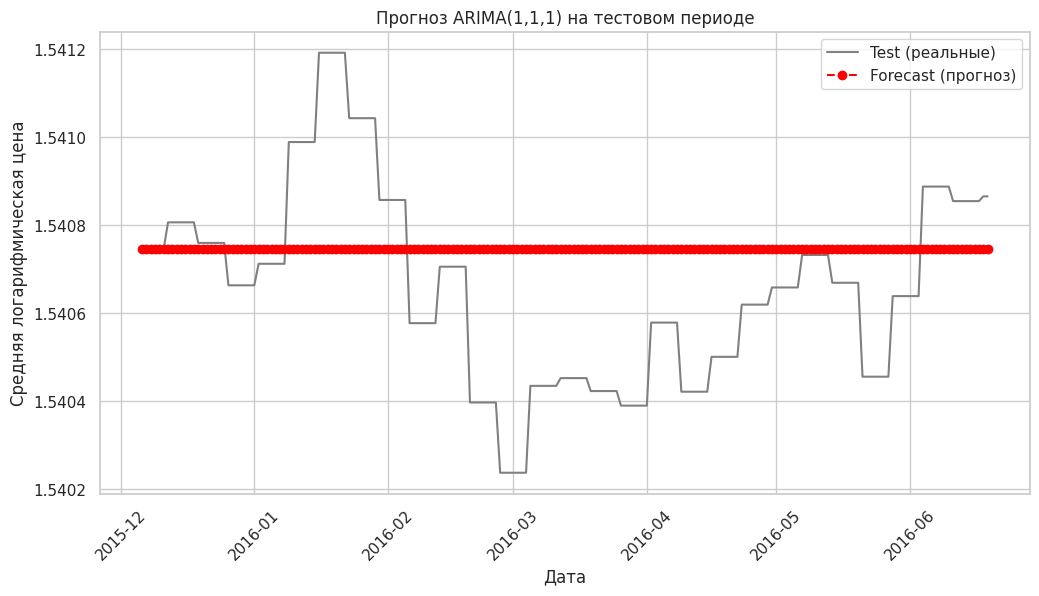

In [77]:
# График прогноза только на тестовом периоде
plt.figure(figsize=(12,6))
plt.plot(test_ts_df.index, test_ts_df, label='Test (реальные)', color='gray')
plt.plot(test_ts_df.index, forecast_final, label='Forecast (прогноз)', color='red', linestyle='--', marker='o')
plt.xlabel('Дата')
plt.ylabel('Средняя логарифмическая цена')
plt.title('Прогноз ARIMA(1,1,1) на тестовом периоде')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

### Дополнительный вывод по прогнозу ARIMA(1,1,1) на тестовом периоде:

При детальном рассмотрении прогноза только на тестовом интервале видно, что модель ARIMA(1,1,1) выдала почти постоянное значение прогноза без учёта краткосрочных колебаний.

Это может быть связано с тем, что модель не способна уловить краткосрочные или сезонные вариации цен, которые, возможно, присутствуют в данных. Несмотря на низкий показатель MAPE (0.0124%), следует учитывать, что ARIMA лучше подходит для прогнозирования долгосрочного тренда, а не краткосрочных колебаний.

In [78]:
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Подготовка данных
train_df_arima = train_df[['date', 'log_sell_price']].copy()
val_df_arima = val_df[['date', 'log_sell_price']].copy()
test_df_arima = test_df[['date', 'log_sell_price']].copy()

def prepare_series(df):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df.resample('D').mean().fillna(method='ffill')

train_series = prepare_series(train_df_arima)
val_series = prepare_series(val_df_arima)
test_series = prepare_series(test_df_arima)

# Обучаем модель только на train_series
final_order = (1, 1, 1)
model_correct = ARIMA(train_series, order=final_order)
model_correct_fit = model_correct.fit()

# Прогноз на train, val и test без утечки данных
train_pred = model_correct_fit.predict(start=train_series.index[0], end=train_series.index[-1])
val_pred = model_correct_fit.forecast(steps=len(val_series))
test_pred = model_correct_fit.forecast(steps=len(val_series) + len(test_series))[len(val_series):]

# Безопасный расчёт MAPE
def safe_mape(y_true, y_pred, epsilon=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Корректный расчёт метрик
metrics_correct = {
    'train_metrics': {
        'MAE': mean_absolute_error(train_series, train_pred),
        'MSE': mean_squared_error(train_series, train_pred),
        'RMSE': np.sqrt(mean_squared_error(train_series, train_pred)),
        'MAPE': safe_mape(train_series.values, train_pred.values),
        'R2': r2_score(train_series, train_pred),
    },
    'val_metrics': {
        'MAE': mean_absolute_error(val_series, val_pred),
        'MSE': mean_squared_error(val_series, val_pred),
        'RMSE': np.sqrt(mean_squared_error(val_series, val_pred)),
        'MAPE': safe_mape(val_series.values, val_pred.values),
        'R2': r2_score(val_series, val_pred),
    },
    'test_metrics': {
        'MAE': mean_absolute_error(test_series, test_pred),
        'MSE': mean_squared_error(test_series, test_pred),
        'RMSE': np.sqrt(mean_squared_error(test_series, test_pred)),
        'MAPE': safe_mape(test_series.values, test_pred.values),
        'R2': r2_score(test_series, test_pred),
    }
}

# Сохранение модели и метрик
model_correct_fit.save(MODELS / 'arima_final_model.pkl')

with open(MODELS / 'arima_final_extended_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_correct, f)

print("Исправленная модель ARIMA и метрики сохранены:")
display(metrics_correct)


Исправленная модель ARIMA и метрики сохранены:


{'train_metrics': {'MAE': 0.0010432064085827257,
  'MSE': 0.0013784823236149967,
  'RMSE': np.float64(0.03712791838515858),
  'MAPE': np.float64(0.7413046211060867),
  'R2': -13.047980807630061},
 'val_metrics': {'MAE': 0.0005019179916007793,
  'MSE': 3.221394978236535e-07,
  'RMSE': np.float64(0.0005675733413609676),
  'MAPE': np.float64(0.032593492012087805),
  'R2': -0.22016732500463476},
 'test_metrics': {'MAE': 0.00030533182839213976,
  'MSE': 1.353657363010044e-07,
  'RMSE': np.float64(0.0003679208288490941),
  'MAPE': np.float64(0.019816425885182135),
  'R2': -1.8505324269643708}}

### Почему R² получился отрицательным?

Отрицательные значения коэффициента детерминации (R²) означают, что прогнозы модели ARIMA(1,1,1) на тестовом и валидационном наборах оказались хуже, чем простой константный прогноз (средним значением целевой переменной).

Это является характерной особенностью модели ARIMA, которая лучше прогнозирует тренды и медленно меняющиеся временные ряды, чем краткосрочные колебания. В текущей задаче это свидетельствует о том, что для более точного краткосрочного прогнозирования цен целесообразнее использовать другие модели, например, бустинговые или нейронные сети (Temporal Fusion Transformer).
